### Environment Setup
This section installs all the necessary dependencies required for the notebook. These libraries include tools for natural language processing, dataset management, and statistical analysis. If you already have a compatible environment, you can skip this step.

In [1]:
# Install dependencies (same as the env file, so you may wish to skip this if running locally / with persistent conda environment)
%pip install transformers
%pip install accelerate
%pip install bitsandbytes
%pip install pyDOE3
%pip install datasets
%pip install torch
%pip install jinja2
%pip install torchmetrics
%pip install tqdm
%pip install jupyter
%pip install pretty-jupyter
%pip install researchpy
%pip install statsmodels
%pip install matplotlib
%pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note

### Library Imports
Here, we import the essential Python libraries and modules that will be used throughout the notebook. These include:
- `transformers` and `datasets` for natural language processing tasks.
- `pyDOE3` for design of experiments.
- `torchmetrics` for evaluation metrics.
- `jinja2` for templating.
- `statsmodels` for statistical modeling.

In [ ]:
import pandas as pd
import csv
import tqdm
import time
import os
import jinja2
import textwrap
import datasets

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from pyDOE3 import *
from torchmetrics.text.rouge import ROUGEScore

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns

import re  # Import regular expression module

from scipy.stats import shapiro
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import levene

### ROUGE Scores and Their Relevance

#### **ROUGE-1**
- **Definition**: Measures the overlap of unigrams (single words) between the candidate (rewritten) text and the reference (original) text.
- **Relevance**: 
  - High **recall** ensures that all key words from the original text are retained in the rewritten version.
  - High **precision** indicates that the rewritten text avoids including unnecessary words not present in the original.
  - **F-Measure** balances precision and recall to provide an overall alignment score.

---

#### **ROUGE-2**
- **Definition**: Measures the overlap of bigrams (two consecutive words) between the candidate and reference text.
- **Relevance**:
  - High **recall** ensures the rewritten text preserves phrasing and contextual meaning from the original.
  - High **precision** confirms that the word pairings are concise and relevant to the original.
  - **F-Measure** assesses the overall similarity in phrasing and flow between the texts.

---

#### **ROUGE-L**
- **Definition**: Evaluates the longest common subsequence (LCS) between the candidate and reference text.
- **Relevance**:
  - High **recall** indicates the rewritten text maintains the sequence and structure of the original.
  - High **precision** ensures that the sequence includes no extraneous content.
  - **F-Measure** provides a balanced metric for assessing structural and sequential fidelity.

---

#### **ROUGE-Lsum**
- **Definition**: Extends ROUGE-L to multi-sentence or paragraph-level comparisons by analyzing the longest common subsequence across text segments.
- **Relevance**:
  - Ensures that the overall structure, coherence, and flow of the rewritten text are consistent with the original at a broader level.
  - Useful for tasks involving longer passages or summaries.

---

These scores collectively evaluate how well the rewritten text adheres to the original, balancing precision (conciseness) and recall (completeness) to ensure the meaning is preserved without unnecessary additions.

In [3]:
df = pd.read_csv("./outputs.csv", delimiter='§', engine='python')
df = df.fillna(16)
df

,model,batch_size,max_new_tokens,input,raw,output,trimmed_output,score,start_time,end_time,time_taken,quantization,repetition_number
0,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"[' I darted diagonally through the street, reg...","{'rouge1_fmeasure': tensor(0.8250), 'rouge1_pr...",1.732998e+09,1.732998e+09,6.452672,4.0,0
1,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['If there were any suggestions of Mendelssohn...,['Instruction: Rewrite the given text while ke...,[' If there were any suggestions of Mendelssoh...,"{'rouge1_fmeasure': tensor(0.7968), 'rouge1_pr...",1.732998e+09,1.732998e+09,4.511077,4.0,0
2,meta-llama/Llama-3.2-1B,1,100,"[""Instruction: Rewrite the given text while ke...","[""Deep Tissue Massage is a form of bodywork th...","[""Instruction: Rewrite the given text while ke...","["" Deep Tissue Massage is a form of bodywork t...","{'rouge1_fmeasure': tensor(0.7449), 'rouge1_pr...",1.732998e+09,1.732998e+09,4.376606,4.0,0
3,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['The procedure for constructing your resume a...,['Instruction: Rewrite the given text while ke...,['1. A procedure for generating a resume and e...,"{'rouge1_fmeasure': tensor(0.7918), 'rouge1_pr...",1.732998e+09,1.732998e+09,4.437645,4.0,0
4,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['A. Action of the Board: The Board upon a fin...,['Instruction: Rewrite the given text while ke...,[' A. Action of the Board: The Board upon a fi...,"{'rouge1_fmeasure': tensor(0.8115), 'rouge1_pr...",1.732998e+09,1.732998e+09,4.466196,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,"[' In 1884, Teodor Burada discovered the first...","{'rouge1_fmeasure': tensor(0.4742), 'rouge1_pr...",1.733171e+09,1.733171e+09,77.679033,16.0,1
2021,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', ' If there were any suggestions of Dohnán...","{'rouge1_fmeasure': tensor(0.6431), 'rouge1_pr...",1.733171e+09,1.733171e+09,81.586453,16.0,2
2022,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,[' The culture takes its name from the village...,"{'rouge1_fmeasure': tensor(0.7051), 'rouge1_pr...",1.733171e+09,1.733171e+09,28.464533,16.0,2
2023,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,"[""Instruction: Rewrite the given text while ke...","["" Caught red-handed by the pedestrian's roadb...","{'rouge1_fmeasure': tensor(0.6180), 'rouge1_pr...",1.733171e+09,1.733171e+09,81.668655,16.0,3


In [4]:
# Function to safely extract numeric value from a tensor string like 'tensor(0.8250)'
def extract_tensor_value(value):
    """ Extracts the float value from a tensor string like 'tensor(0.8250)' """
    if isinstance(value, str):
        # Replace 'tensor(' and ')' to extract the numeric value
        tensor_match = re.match(r"tensor\(([^)]+)\)", value)
        if tensor_match:
            return float(tensor_match.group(1))
    return value  # Return the value if it's already numeric

# Function to parse the 'score' column and convert it to a dictionary with float values
def parse_score_column(score_str):
    """ Convert the score string to a dictionary with tensor values extracted """
    # First replace tensor-like patterns with numeric values
    score_str = re.sub(r"tensor\(([^)]+)\)", r"\1", score_str)  # Replace 'tensor(x)' with 'x'
    
    # Safely evaluate the dictionary string
    score_dict = eval(score_str)  # This converts the cleaned-up string to a dictionary

    # Convert all values in the dictionary to float if they are tensor-like strings
    for key, value in score_dict.items():
        score_dict[key] = extract_tensor_value(value)
    
    return score_dict

# Apply the function to the 'score' column to convert to dictionaries with float values
df['score'] = df['score'].apply(parse_score_column)

# Now, extract the individual ROUGE metrics and convert them into separate columns
df['rouge1_fmeasure'] = df['score'].apply(lambda x: x['rouge1_fmeasure'])
df['rouge1_precision'] = df['score'].apply(lambda x: x['rouge1_precision'])
df['rouge1_recall'] = df['score'].apply(lambda x: x['rouge1_recall'])
df['rouge2_fmeasure'] = df['score'].apply(lambda x: x['rouge2_fmeasure'])
df['rouge2_precision'] = df['score'].apply(lambda x: x['rouge2_precision'])
df['rouge2_recall'] = df['score'].apply(lambda x: x['rouge2_recall'])
df['rougeL_fmeasure'] = df['score'].apply(lambda x: x['rougeL_fmeasure'])
df['rougeL_precision'] = df['score'].apply(lambda x: x['rougeL_precision'])
df['rougeL_recall'] = df['score'].apply(lambda x: x['rougeL_recall'])
df['rougeLsum_fmeasure'] = df['score'].apply(lambda x: x['rougeLsum_fmeasure'])
df['rougeLsum_precision'] = df['score'].apply(lambda x: x['rougeLsum_precision'])
df['rougeLsum_recall'] = df['score'].apply(lambda x: x['rougeLsum_recall'])

In [5]:
df

,model,batch_size,max_new_tokens,input,raw,output,trimmed_output,score,start_time,end_time,...,rouge1_recall,rouge2_fmeasure,rouge2_precision,rouge2_recall,rougeL_fmeasure,rougeL_precision,rougeL_recall,rougeLsum_fmeasure,rougeLsum_precision,rougeLsum_recall
0,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"[' I darted diagonally through the street, reg...","{'rouge1_fmeasure': 0.825, 'rouge1_precision':...",1.732998e+09,1.732998e+09,...,1.0,0.8241,0.7009,1.0,0.8250,0.7021,1.0,0.8250,0.7021,1.0
1,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['If there were any suggestions of Mendelssohn...,['Instruction: Rewrite the given text while ke...,[' If there were any suggestions of Mendelssoh...,"{'rouge1_fmeasure': 0.7968, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,1.0,0.7958,0.6608,1.0,0.7968,0.6623,1.0,0.7968,0.6623,1.0
2,meta-llama/Llama-3.2-1B,1,100,"[""Instruction: Rewrite the given text while ke...","[""Deep Tissue Massage is a form of bodywork th...","[""Instruction: Rewrite the given text while ke...","["" Deep Tissue Massage is a form of bodywork t...","{'rouge1_fmeasure': 0.7449, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,1.0,0.7434,0.5915,1.0,0.7449,0.5935,1.0,0.7449,0.5935,1.0
3,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['The procedure for constructing your resume a...,['Instruction: Rewrite the given text while ke...,['1. A procedure for generating a resume and e...,"{'rouge1_fmeasure': 0.7918, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,1.0,0.7907,0.6538,1.0,0.7918,0.6553,1.0,0.7918,0.6553,1.0
4,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['A. Action of the Board: The Board upon a fin...,['Instruction: Rewrite the given text while ke...,[' A. Action of the Board: The Board upon a fi...,"{'rouge1_fmeasure': 0.8115, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,1.0,0.8107,0.6816,1.0,0.8115,0.6828,1.0,0.8115,0.6828,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,"[' In 1884, Teodor Burada discovered the first...","{'rouge1_fmeasure': 0.4742, 'rouge1_precision'...",1.733171e+09,1.733171e+09,...,1.0,0.4724,0.3131,1.0,0.4742,0.3147,1.0,0.4742,0.3147,1.0
2021,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', ' If there were any suggestions of Dohnán...","{'rouge1_fmeasure': 0.6431, 'rouge1_precision'...",1.733171e+09,1.733171e+09,...,1.0,0.6418,0.5029,1.0,0.6431,0.5043,1.0,0.6431,0.5043,1.0
2022,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,[' The culture takes its name from the village...,"{'rouge1_fmeasure': 0.7051, 'rouge1_precision'...",1.733171e+09,1.733171e+09,...,1.0,0.7036,0.5428,1.0,0.7051,0.5446,1.0,0.7051,0.5446,1.0
2023,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,"[""Instruction: Rewrite the given text while ke...","["" Caught red-handed by the pedestrian's roadb...","{'rouge1_fmeasure': 0.618, 'rouge1_precision':...",1.733171e+09,1.733171e+09,...,1.0,0.6165,0.4574,1.0,0.6180,0.4590,1.0,0.6180,0.4590,1.0


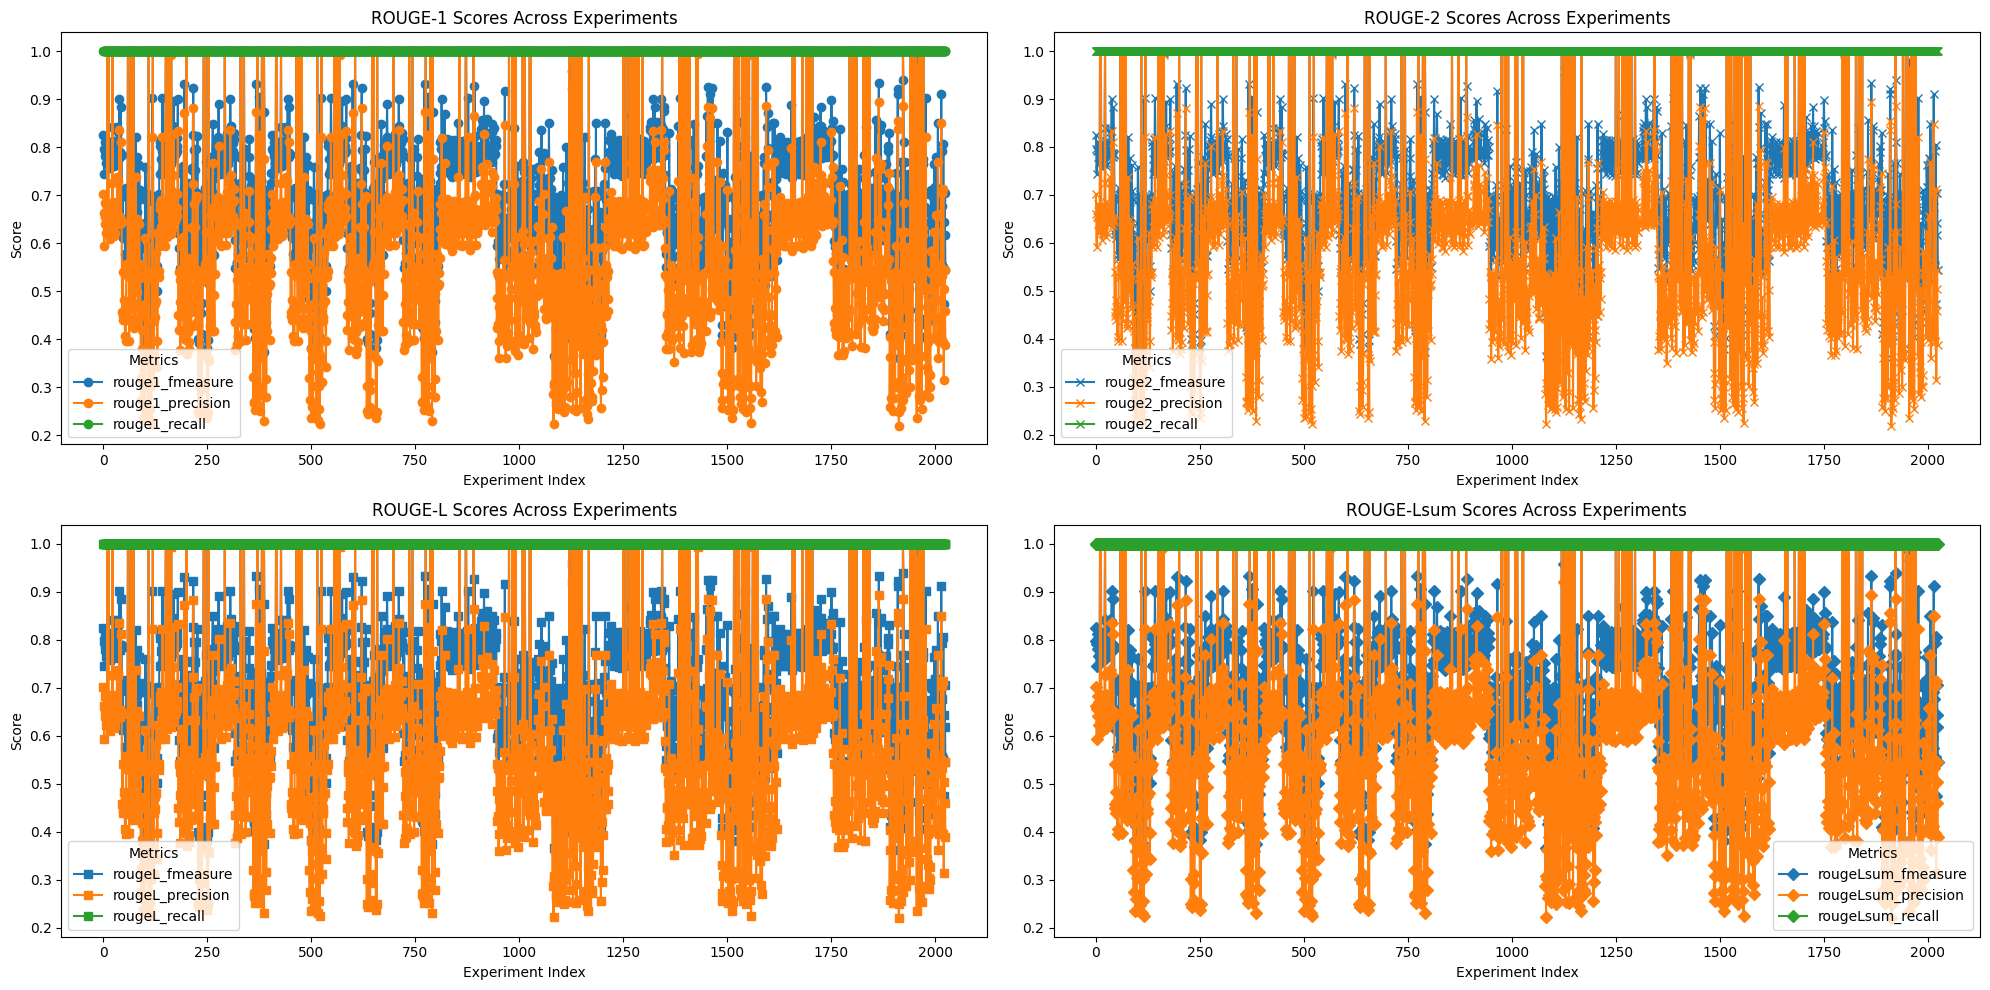

In [6]:
plt.figure(figsize=(20, 10))

# ROUGE-1
plt.subplot(2, 2, 1)
df[['rouge1_fmeasure', 'rouge1_precision', 'rouge1_recall']].plot(ax=plt.gca(), marker='o')
plt.title("ROUGE-1 Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-2
plt.subplot(2, 2, 2)
df[['rouge2_fmeasure', 'rouge2_precision', 'rouge2_recall']].plot(ax=plt.gca(), marker='x')
plt.title("ROUGE-2 Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-L
plt.subplot(2, 2, 3)
df[['rougeL_fmeasure', 'rougeL_precision', 'rougeL_recall']].plot(ax=plt.gca(), marker='s')
plt.title("ROUGE-L Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-Lsum
plt.subplot(2, 2, 4)
df[['rougeLsum_fmeasure', 'rougeLsum_precision', 'rougeLsum_recall']].plot(ax=plt.gca(), marker='D')
plt.title("ROUGE-Lsum Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# Display the plots
plt.tight_layout()
plt.show()

In [7]:
df['configuration'] = df[['model', 'batch_size', 'max_new_tokens', 'quantization']].astype(str).agg('§'.join, axis=1)
df

,model,batch_size,max_new_tokens,input,raw,output,trimmed_output,score,start_time,end_time,...,rouge2_fmeasure,rouge2_precision,rouge2_recall,rougeL_fmeasure,rougeL_precision,rougeL_recall,rougeLsum_fmeasure,rougeLsum_precision,rougeLsum_recall,configuration
0,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"[' I darted diagonally through the street, reg...","{'rouge1_fmeasure': 0.825, 'rouge1_precision':...",1.732998e+09,1.732998e+09,...,0.8241,0.7009,1.0,0.8250,0.7021,1.0,0.8250,0.7021,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
1,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['If there were any suggestions of Mendelssohn...,['Instruction: Rewrite the given text while ke...,[' If there were any suggestions of Mendelssoh...,"{'rouge1_fmeasure': 0.7968, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,0.7958,0.6608,1.0,0.7968,0.6623,1.0,0.7968,0.6623,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
2,meta-llama/Llama-3.2-1B,1,100,"[""Instruction: Rewrite the given text while ke...","[""Deep Tissue Massage is a form of bodywork th...","[""Instruction: Rewrite the given text while ke...","["" Deep Tissue Massage is a form of bodywork t...","{'rouge1_fmeasure': 0.7449, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,0.7434,0.5915,1.0,0.7449,0.5935,1.0,0.7449,0.5935,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
3,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['The procedure for constructing your resume a...,['Instruction: Rewrite the given text while ke...,['1. A procedure for generating a resume and e...,"{'rouge1_fmeasure': 0.7918, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,0.7907,0.6538,1.0,0.7918,0.6553,1.0,0.7918,0.6553,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
4,meta-llama/Llama-3.2-1B,1,100,['Instruction: Rewrite the given text while ke...,['A. Action of the Board: The Board upon a fin...,['Instruction: Rewrite the given text while ke...,[' A. Action of the Board: The Board upon a fi...,"{'rouge1_fmeasure': 0.8115, 'rouge1_precision'...",1.732998e+09,1.732998e+09,...,0.8107,0.6816,1.0,0.8115,0.6828,1.0,0.8115,0.6828,1.0,meta-llama/Llama-3.2-1B§1§100§4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,"[' In 1884, Teodor Burada discovered the first...","{'rouge1_fmeasure': 0.4742, 'rouge1_precision'...",1.733171e+09,1.733171e+09,...,0.4724,0.3131,1.0,0.4742,0.3147,1.0,0.4742,0.3147,1.0,meta-llama/Llama-3.1-8B§8§500§16.0
2021,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,['Instruction: Rewrite the given text while ke...,"['', ' If there were any suggestions of Dohnán...","{'rouge1_fmeasure': 0.6431, 'rouge1_precision'...",1.733171e+09,1.733171e+09,...,0.6418,0.5029,1.0,0.6431,0.5043,1.0,0.6431,0.5043,1.0,meta-llama/Llama-3.1-8B§8§500§16.0
2022,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['The culture takes its name from the village ...,['Instruction: Rewrite the given text while ke...,[' The culture takes its name from the village...,"{'rouge1_fmeasure': 0.7051, 'rouge1_precision'...",1.733171e+09,1.733171e+09,...,0.7036,0.5428,1.0,0.7051,0.5446,1.0,0.7051,0.5446,1.0,meta-llama/Llama-3.1-8B§8§500§16.0
2023,meta-llama/Llama-3.1-8B,8,500,['Instruction: Rewrite the given text while ke...,['Caught red handed by the pedestrian’s roadbl...,"[""Instruction: Rewrite the given text while ke...","["" Caught red-handed by the pedestrian's roadb...","{'rouge1_fmeasure': 0.618, 'rouge1_precision':...",1.733171e+09,1.733171e+09,...,0.6165,0.4574,1.0,0.6180,0.4590,1.0,0.6180,0.4590,1.0,meta-llama/Llama-3.1-8B§8§500§

In [8]:
df.columns, len(df), len(df.columns), df['configuration'].nunique()

(Index(['model', 'batch_size', 'max_new_tokens', 'input', 'raw', 'output',
        'trimmed_output', 'score', 'start_time', 'end_time', 'time_taken',
        'quantization', 'repetition_number', 'rouge1_fmeasure',
        'rouge1_precision', 'rouge1_recall', 'rouge2_fmeasure',
        'rouge2_precision', 'rouge2_recall', 'rougeL_fmeasure',
        'rougeL_precision', 'rougeL_recall', 'rougeLsum_fmeasure',
        'rougeLsum_precision', 'rougeLsum_recall', 'configuration'],
       dtype='object'),
 2025,
 26,
 81)

In [9]:
df["rouge1_precision"]

0       0.7021
1       0.6623
2       0.5935
3       0.6553
4       0.6828
         ...  
2020    0.3147
2021    0.5043
2022    0.5446
2023    0.4590
2024    0.3890
Name: rouge1_precision, Length: 2025, dtype: float64

Total number of unique configurations: 81


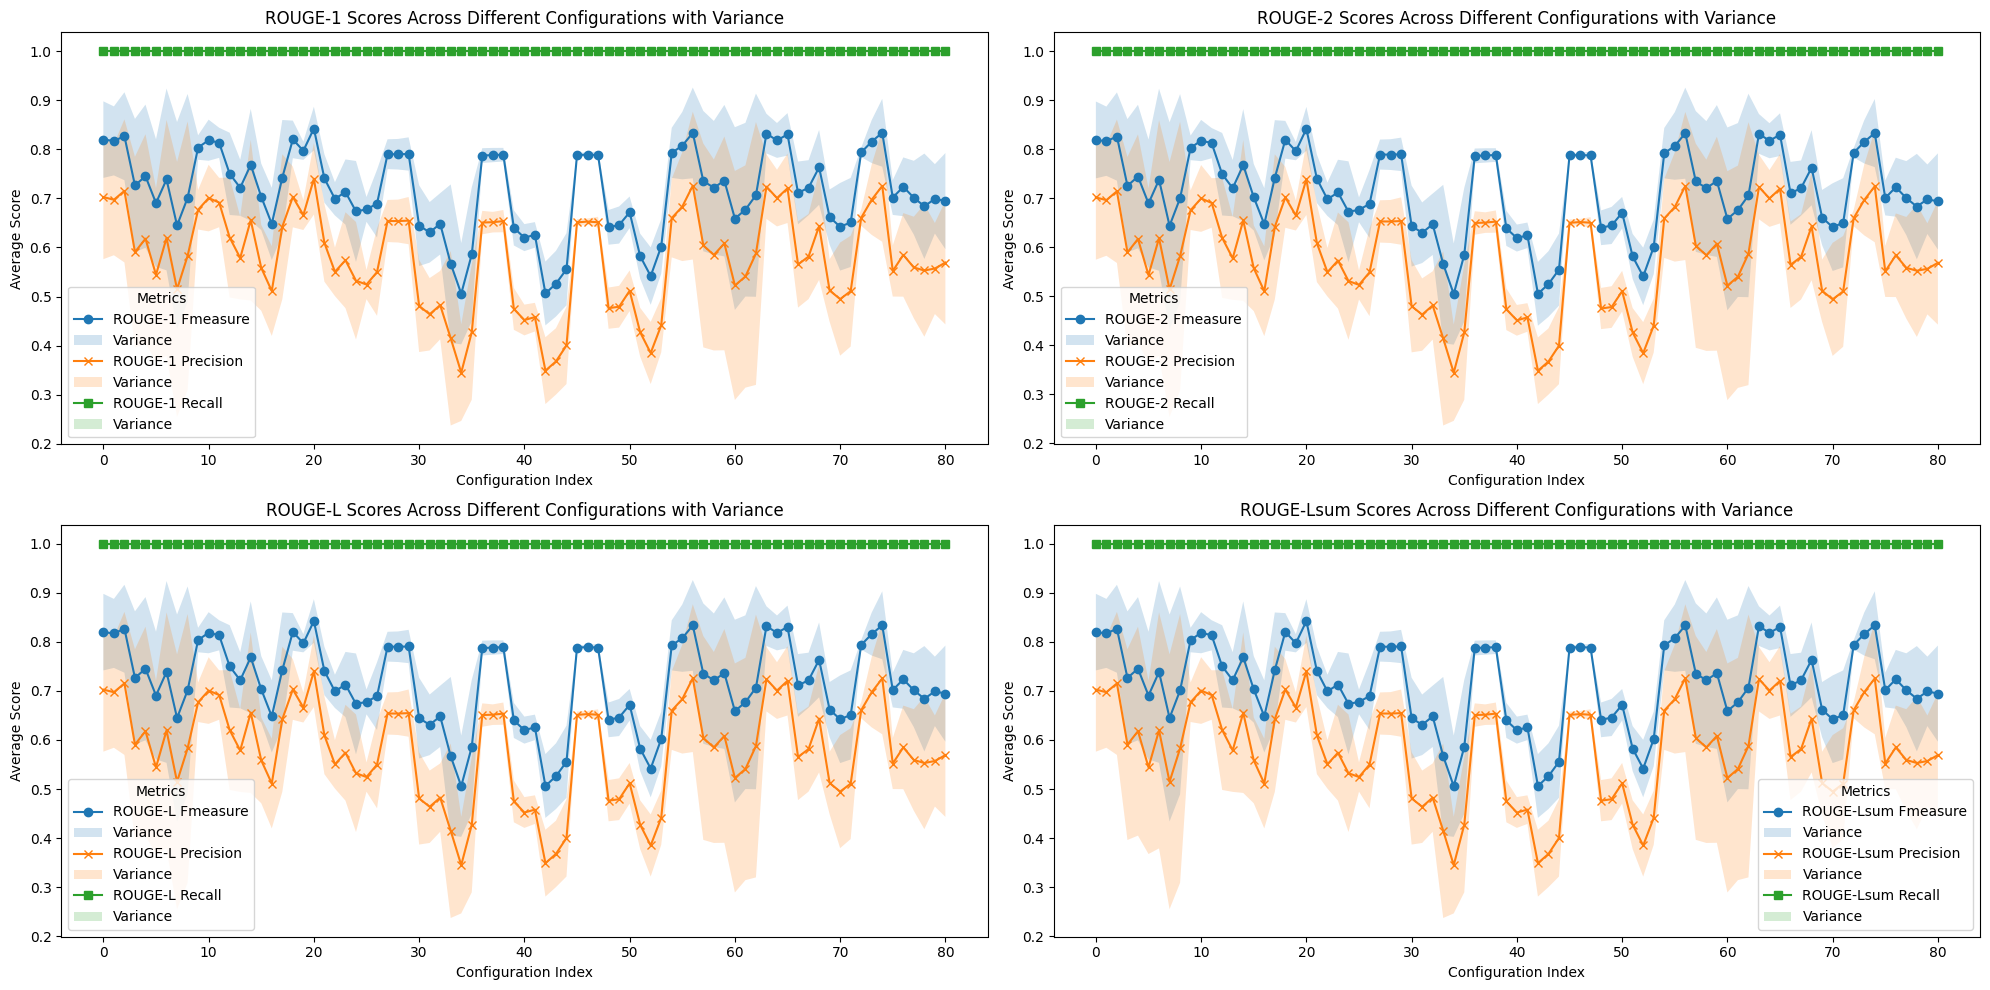

In [10]:
# Group by the complete configuration and calculate the mean and variance
grouped_df = df.groupby('configuration').agg(
    rouge1_fmeasure_mean=('rouge1_fmeasure', 'mean'),
    rouge1_fmeasure_var=('rouge1_fmeasure', 'var'),
    rouge1_precision_mean=('rouge1_precision', 'mean'),
    rouge1_precision_var=('rouge1_precision', 'var'),
    rouge1_recall_mean=('rouge1_recall', 'mean'),
    rouge1_recall_var=('rouge1_recall', 'var'),
    rouge2_fmeasure_mean=('rouge2_fmeasure', 'mean'),
    rouge2_fmeasure_var=('rouge2_fmeasure', 'var'),
    rouge2_precision_mean=('rouge2_precision', 'mean'),
    rouge2_precision_var=('rouge2_precision', 'var'),
    rouge2_recall_mean=('rouge2_recall', 'mean'),
    rouge2_recall_var=('rouge2_recall', 'var'),
    rougeL_fmeasure_mean=('rougeL_fmeasure', 'mean'),
    rougeL_fmeasure_var=('rougeL_fmeasure', 'var'),
    rougeL_precision_mean=('rougeL_precision', 'mean'),
    rougeL_precision_var=('rougeL_precision', 'var'),
    rougeL_recall_mean=('rougeL_recall', 'mean'),
    rougeL_recall_var=('rougeL_recall', 'var'),
    rougeLsum_fmeasure_mean=('rougeLsum_fmeasure', 'mean'),
    rougeLsum_fmeasure_var=('rougeLsum_fmeasure', 'var'),
    rougeLsum_precision_mean=('rougeLsum_precision', 'mean'),
    rougeLsum_precision_var=('rougeLsum_precision', 'var'),
    rougeLsum_recall_mean=('rougeLsum_recall', 'mean'),
    rougeLsum_recall_var=('rougeLsum_recall', 'var'),
).reset_index()

# Make sure the grouping contains 81 configurations by checking the number of unique configurations
print(f"Total number of unique configurations: {grouped_df.shape[0]}")  # This should be 81

plt.figure(figsize=(20, 10))

# ROUGE-1
plt.subplot(2, 2, 1)
plt.plot(grouped_df.index, grouped_df['rouge1_fmeasure_mean'], marker='o', label='ROUGE-1 Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_fmeasure_mean'] - grouped_df['rouge1_fmeasure_var']**0.5, 
                 grouped_df['rouge1_fmeasure_mean'] + grouped_df['rouge1_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge1_precision_mean'], marker='x', label='ROUGE-1 Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_precision_mean'] - grouped_df['rouge1_precision_var']**0.5, 
                 grouped_df['rouge1_precision_mean'] + grouped_df['rouge1_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge1_recall_mean'], marker='s', label='ROUGE-1 Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_recall_mean'] - grouped_df['rouge1_recall_var']**0.5, 
                 grouped_df['rouge1_recall_mean'] + grouped_df['rouge1_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-1 Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-2
plt.subplot(2, 2, 2)
plt.plot(grouped_df.index, grouped_df['rouge2_fmeasure_mean'], marker='o', label='ROUGE-2 Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_fmeasure_mean'] - grouped_df['rouge2_fmeasure_var']**0.5, 
                 grouped_df['rouge2_fmeasure_mean'] + grouped_df['rouge2_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge2_precision_mean'], marker='x', label='ROUGE-2 Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_precision_mean'] - grouped_df['rouge2_precision_var']**0.5, 
                 grouped_df['rouge2_precision_mean'] + grouped_df['rouge2_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge2_recall_mean'], marker='s', label='ROUGE-2 Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_recall_mean'] - grouped_df['rouge2_recall_var']**0.5, 
                 grouped_df['rouge2_recall_mean'] + grouped_df['rouge2_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-2 Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-L
plt.subplot(2, 2, 3)
plt.plot(grouped_df.index, grouped_df['rougeL_fmeasure_mean'], marker='o', label='ROUGE-L Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_fmeasure_mean'] - grouped_df['rougeL_fmeasure_var']**0.5, 
                 grouped_df['rougeL_fmeasure_mean'] + grouped_df['rougeL_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeL_precision_mean'], marker='x', label='ROUGE-L Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_precision_mean'] - grouped_df['rougeL_precision_var']**0.5, 
                 grouped_df['rougeL_precision_mean'] + grouped_df['rougeL_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeL_recall_mean'], marker='s', label='ROUGE-L Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_recall_mean'] - grouped_df['rougeL_recall_var']**0.5,
                    grouped_df['rougeL_recall_mean'] + grouped_df['rougeL_recall_var']**0.5,
                    alpha=0.2, label='Variance')
plt.title("ROUGE-L Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-Lsum
plt.subplot(2, 2, 4)
plt.plot(grouped_df.index, grouped_df['rougeLsum_fmeasure_mean'], marker='o', label='ROUGE-Lsum Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_fmeasure_mean'] - grouped_df['rougeLsum_fmeasure_var']**0.5, 
                 grouped_df['rougeLsum_fmeasure_mean'] + grouped_df['rougeLsum_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeLsum_precision_mean'], marker='x', label='ROUGE-Lsum Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_precision_mean'] - grouped_df['rougeLsum_precision_var']**0.5, 
                 grouped_df['rougeLsum_precision_mean'] + grouped_df['rougeLsum_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeLsum_recall_mean'], marker='s', label='ROUGE-Lsum Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_recall_mean'] - grouped_df['rougeLsum_recall_var']**0.5, 
                 grouped_df['rougeLsum_recall_mean'] + grouped_df['rougeLsum_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-Lsum Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# Display the plots
plt.tight_layout()

In [11]:
grouped_df

,configuration,rouge1_fmeasure_mean,rouge1_fmeasure_var,rouge1_precision_mean,rouge1_precision_var,rouge1_recall_mean,rouge1_recall_var,rouge2_fmeasure_mean,rouge2_fmeasure_var,rouge2_precision_mean,...,rougeL_precision_mean,rougeL_precision_var,rougeL_recall_mean,rougeL_recall_var,rougeLsum_fmeasure_mean,rougeLsum_fmeasure_var,rougeLsum_precision_mean,rougeLsum_precision_var,rougeLsum_recall_mean,rougeLsum_recall_var
0,meta-llama/Llama-3.1-8B§1§100§16.0,0.819658,0.006079,0.702584,0.015963,1.0,0.0,0.818678,0.006147,0.701250,...,0.702584,0.015963,1.0,0.0,0.819658,0.006079,0.702584,0.015963,1.0,0.0
1,meta-llama/Llama-3.1-8B§1§100§4.0,0.817062,0.004936,0.697278,0.012790,1.0,0.0,0.816068,0.004992,0.695916,...,0.697278,0.012790,1.0,0.0,0.817062,0.004936,0.697278,0.012790,1.0,0.0
2,meta-llama/Llama-3.1-8B§1§100§8.0,0.826506,0.008017,0.715216,0.021212,1.0,0.0,0.825574,0.008106,0.713946,...,0.715216,0.021212,1.0,0.0,0.826506,0.008017,0.715216,0.021212,1.0,0.0
3,meta-llama/Llama-3.1-8B§1§250§16.0,0.726438,0.018348,0.590548,0.037708,1.0,0.0,0.725194,0.018501,0.589146,...,0.590548,0.037708,1.0,0.0,0.726438,0.018348,0.590548,0.037708,1.0,0.0
4,meta-llama/Llama-3.1-8B§1§250§4.0,0.745152,0.021268,0.617950,0.045238,1.0,0.0,0.743988,0.021452,0.616640,...,0.617950,0.045238,1.0,0.0,0.745152,0.021268,0.617950,0.045238,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,meta-llama/Llama-3.2-3B§8§250§4.0,0.723560,0.003586,0.584950,0.007241,1.0,0.0,0.722260,0.003617,0.583440,...,0.584950,0.007241,1.0,0.0,0.723560,0.003586,0.584950,0.007241,1.0,0.0
77,meta-llama/Llama-3.2-3B§8§250§8.0,0.701370,0.005648,0.559270,0.010701,1.0,0.0,0.700010,0.005691,0.557760,...,0.559270,0.010701,1.0,0.0,0.701370,0.005648,0.559270,0.010701,1.0,0.0
78,meta-llama/Llama-3.2-3B§8§500§16.0,0.683960,0.011508,0.553150,0.018168,1.0,0.0,0.682670,0.011577,0.551790,...,0.553150,0.018168,1.0,0.0,0.683960,0.011508,0.553150,0.018168,1.0,0.0
79,meta-llama/Llama-3.2-3B§8§500§4.0,0.699030,0.004998,0.557190,0.008602,1.0,0.0,0.697690,0.005029,0.555700,...,0.557190,0.008602,1.0,0.0,0.699030,0.004998,0.557190,0.008602,1.0,0.0


Total number of unique configurations: 81


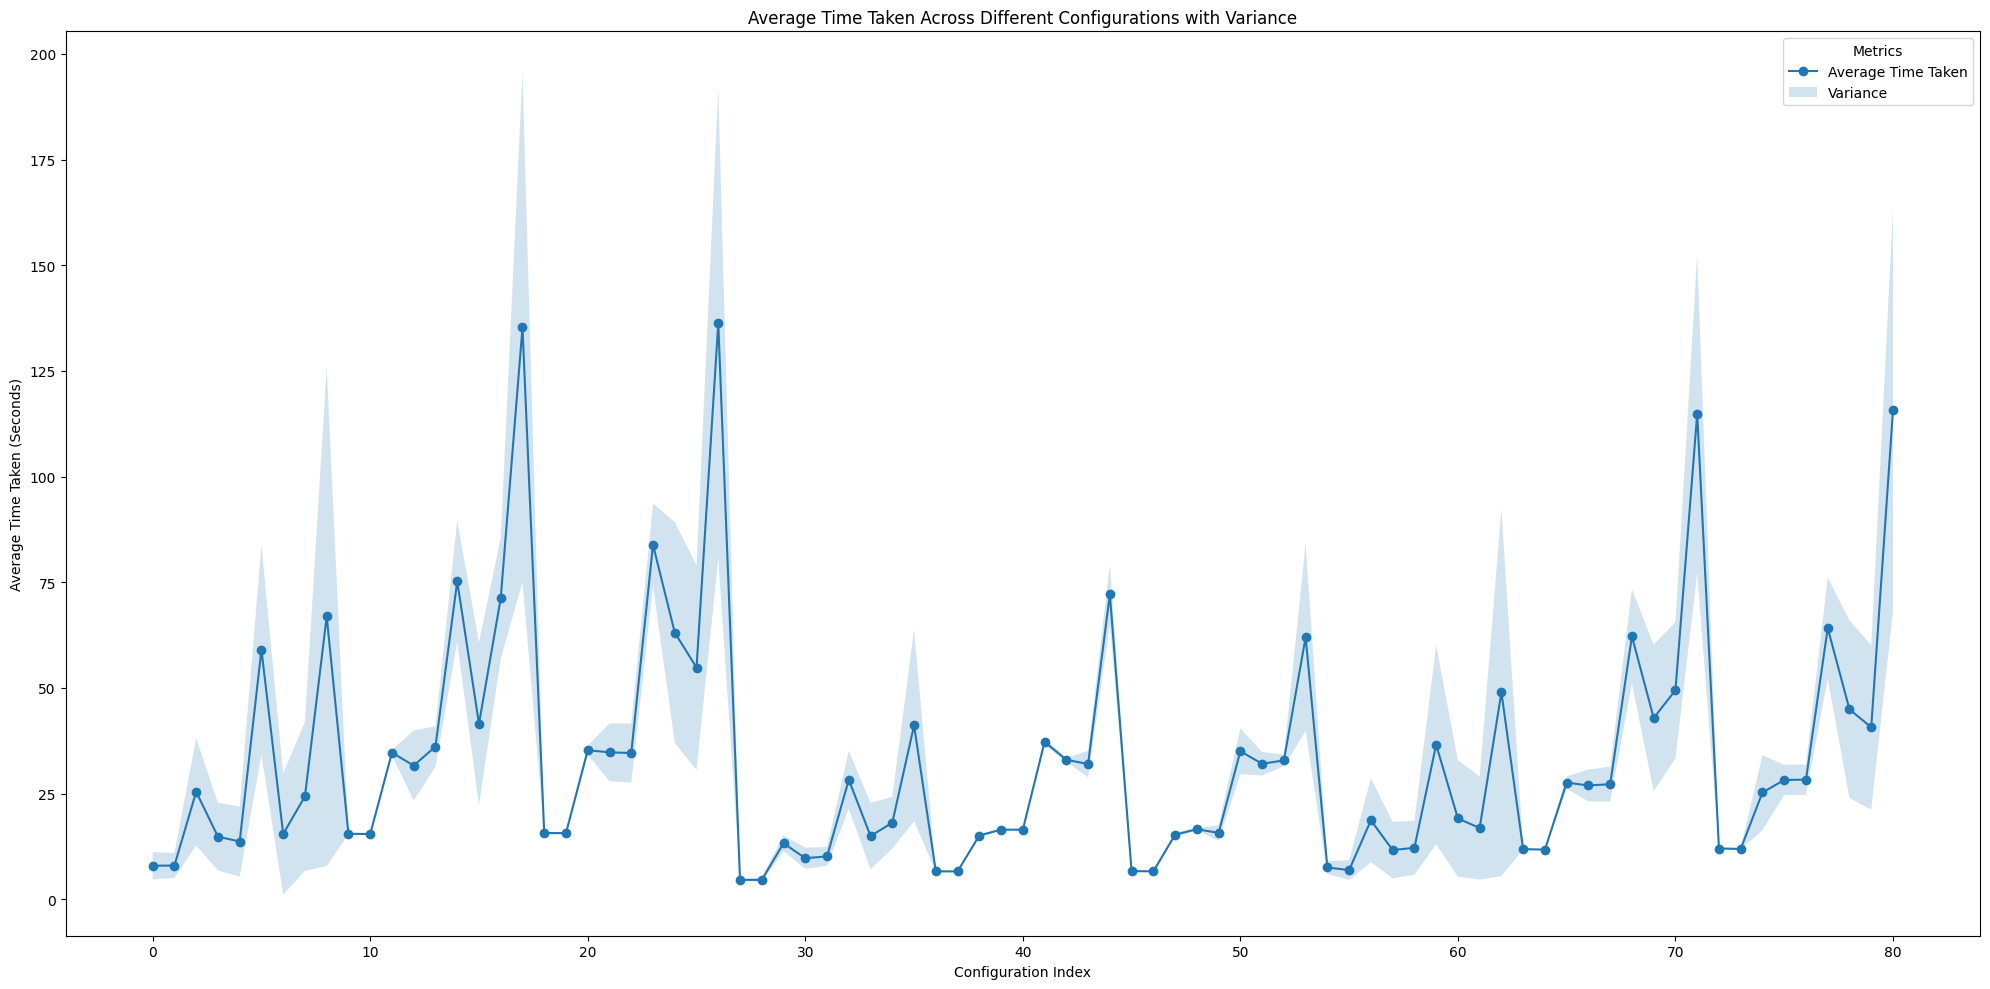

In [12]:
# Group by configuration and calculate the mean and variance for 'time_taken'
grouped_time_df = df.groupby('configuration').agg(
    time_taken_mean=('time_taken', 'mean'),
    time_taken_var=('time_taken', 'var')
).reset_index()

# Make sure the grouping contains the expected number of configurations
print(f"Total number of unique configurations: {grouped_time_df.shape[0]}")  # This should match the expected count (e.g., 81)

# Plotting the 'time_taken' values along with the variance
plt.figure(figsize=(20, 10))

# Plot the average 'time_taken' with error bars for variance
plt.plot(grouped_time_df.index, grouped_time_df['time_taken_mean'], marker='o', label='Average Time Taken')
plt.fill_between(grouped_time_df.index, 
                 grouped_time_df['time_taken_mean'] - grouped_time_df['time_taken_var']**0.5, 
                 grouped_time_df['time_taken_mean'] + grouped_time_df['time_taken_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("Average Time Taken Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Time Taken (Seconds)")
plt.legend(title='Metrics')

# Display the plot
plt.tight_layout()
plt.show()

# Inference time Analysis

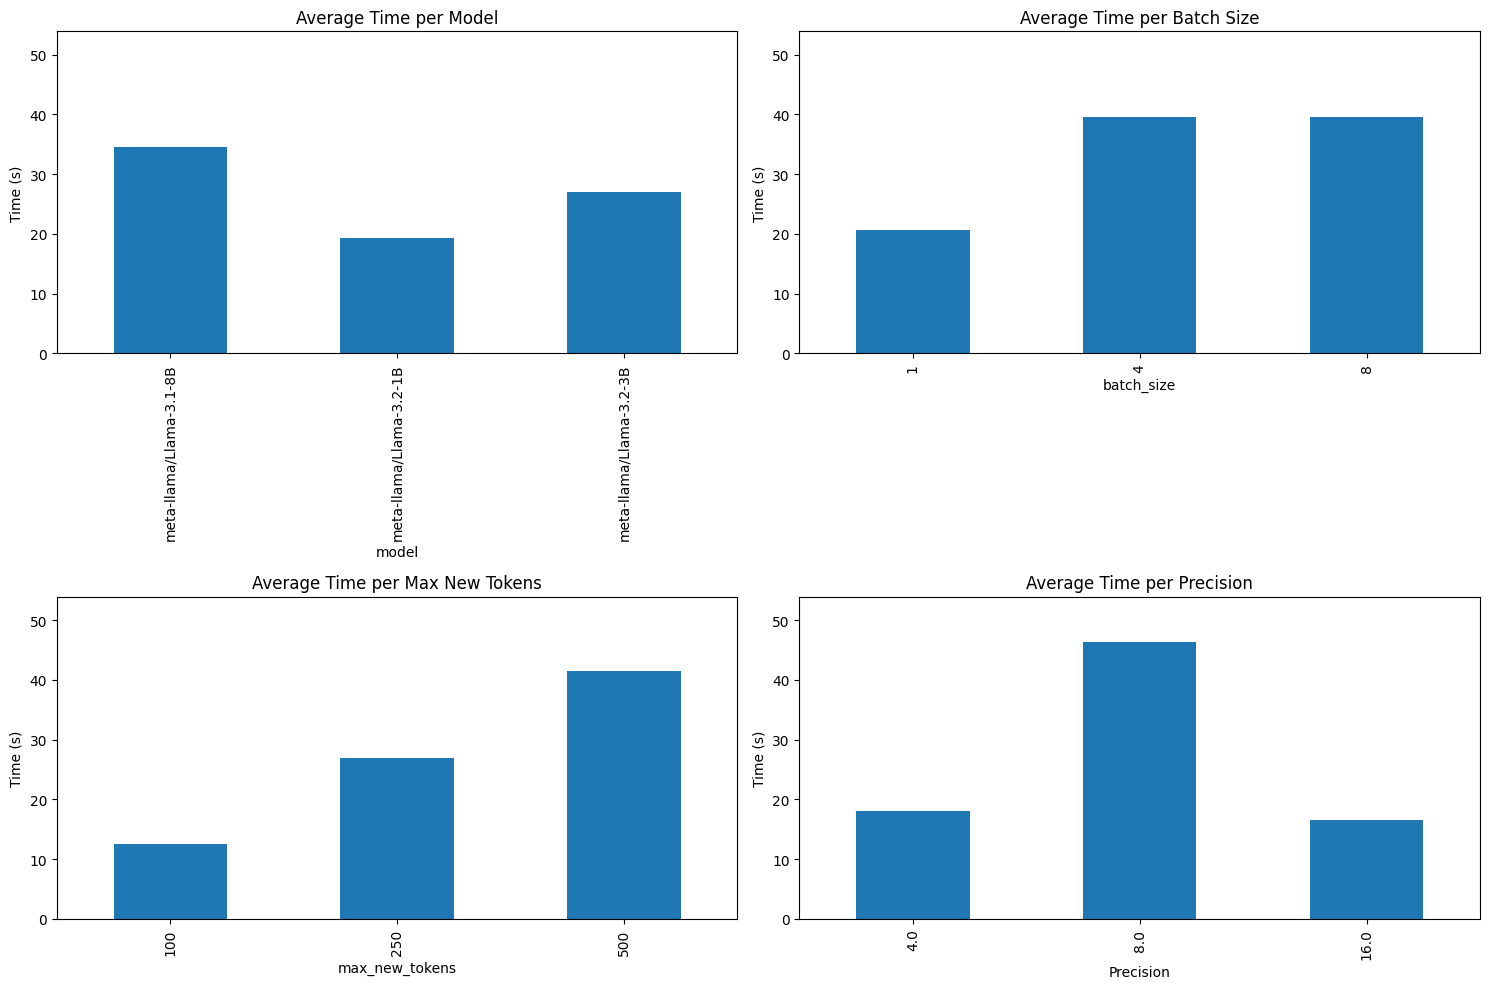

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define consistent y-axis limits
y_min, y_max = 0, df["time_taken"].mean() * 2  # Adjust as needed

# Average Time per Model
df.groupby("model")["time_taken"].mean().plot(
    kind='bar', ax=axes[0, 0], title="Average Time per Model", ylabel="Time (s)")
axes[0, 0].set_ylim(y_min, y_max)

# Average Time per Batch Size
df.groupby("batch_size")["time_taken"].mean().plot(
    kind='bar', ax=axes[0, 1], title="Average Time per Batch Size", ylabel="Time (s)")
axes[0, 1].set_ylim(y_min, y_max)

# Average Time per Max New Tokens
df.groupby("max_new_tokens")["time_taken"].mean().plot(
    kind='bar', ax=axes[1, 0], title="Average Time per Max New Tokens", ylabel="Time (s)")
axes[1, 0].set_ylim(y_min, y_max)

# Average Time per Precision
df.groupby("quantization")["time_taken"].mean().plot(
    kind='bar', ax=axes[1, 1], title="Average Time per Precision", ylabel="Time (s)", xlabel="Precision")
axes[1, 1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


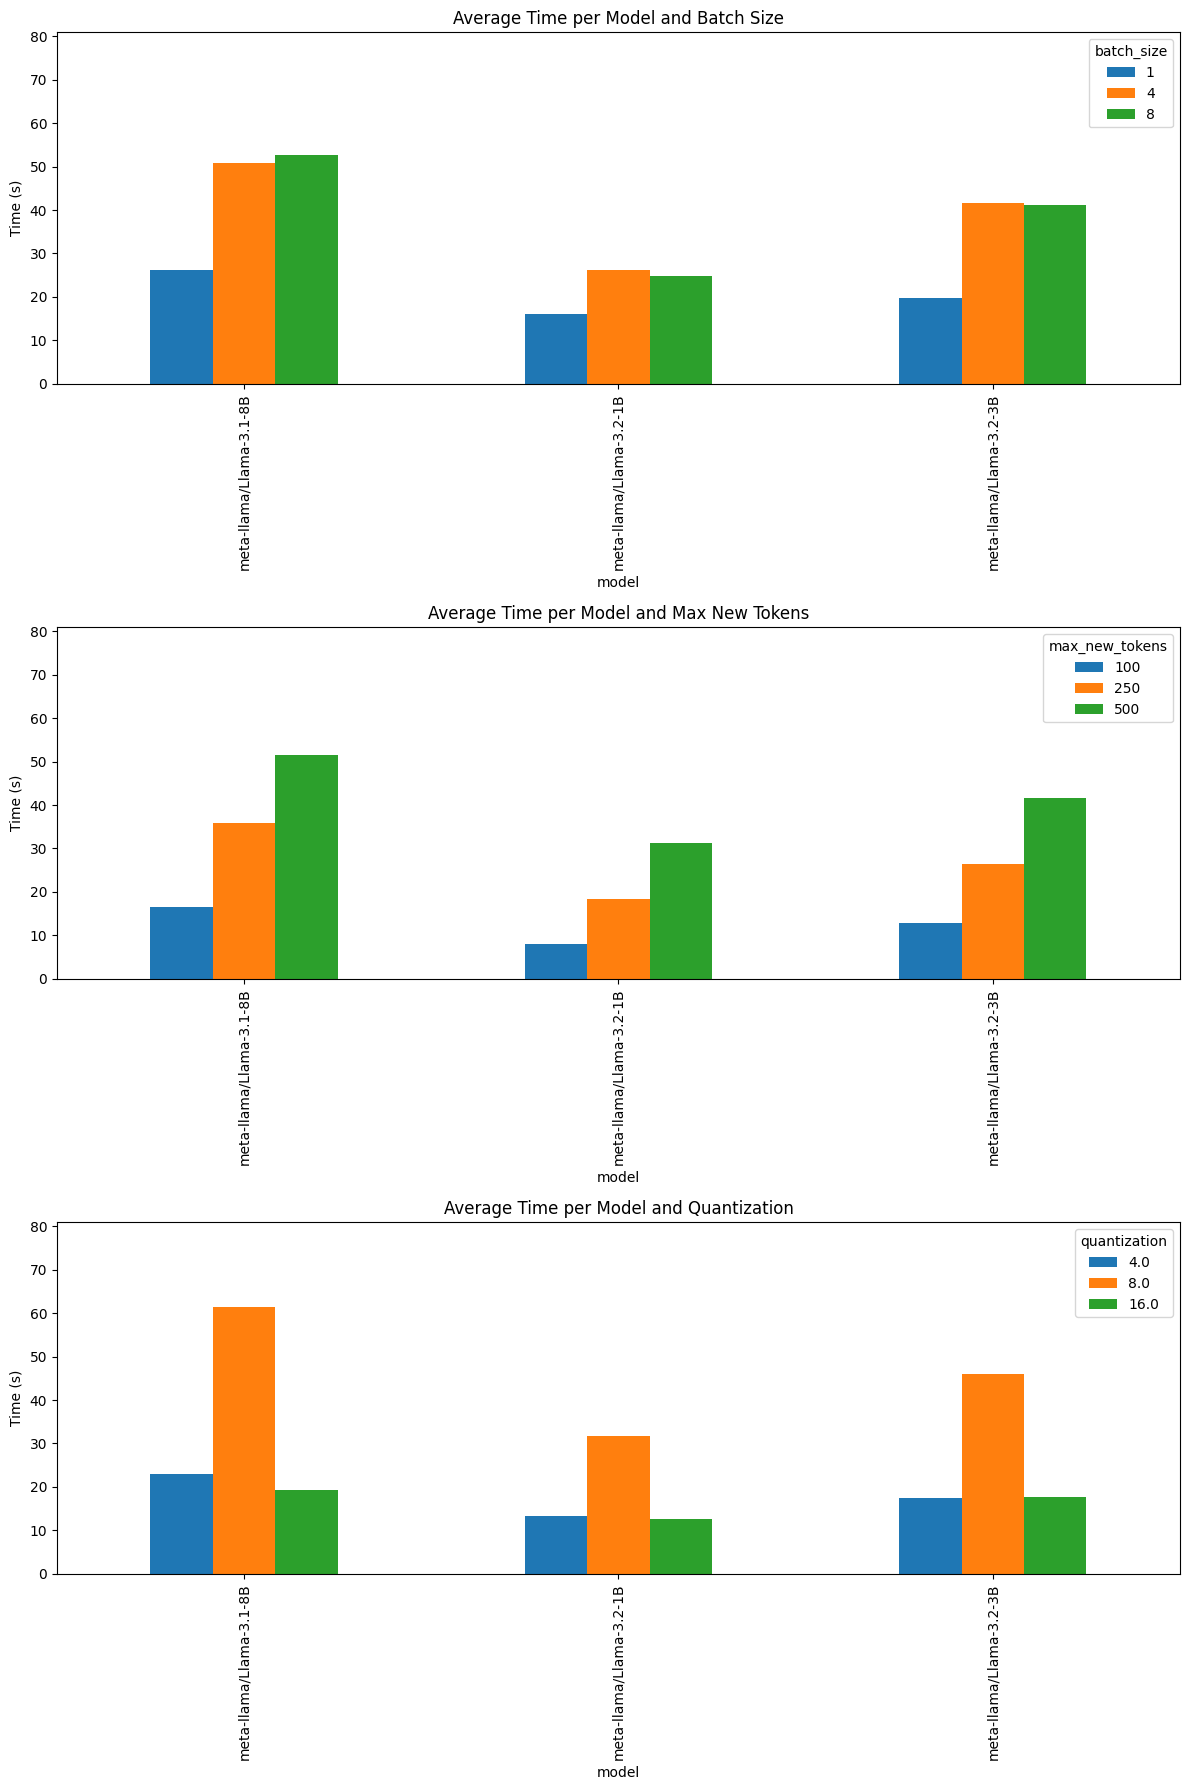

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Define consistent y-axis limits
y_min, y_max = 0, df["time_taken"].mean() * 3  # Adjust as needed

# Average Time per Model and Batch Size
df.groupby(["model", "batch_size"])["time_taken"].mean().unstack().plot(
    kind='bar', ax=axes[0], title="Average Time per Model and Batch Size", ylabel="Time (s)")
axes[0].set_ylim(y_min, y_max)

# Average Time per Model and Max New Tokens
df.groupby(["model", "max_new_tokens"])["time_taken"].mean().unstack().plot(
    kind='bar', ax=axes[1], title="Average Time per Model and Max New Tokens", ylabel="Time (s)")
axes[1].set_ylim(y_min, y_max)

# Average Time per Model and Quantization
df.groupby(["model", "quantization"])["time_taken"].mean().unstack().plot(
    kind='bar', ax=axes[2], title="Average Time per Model and Quantization", ylabel="Time (s)")
axes[2].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# ANOVA Analysis

In [20]:
# Average Time per configuration 
grouped_time_df

# Merge the grouped_df and grouped_time_df DataFrames on the 'configuration' column
merged_df = pd.merge(grouped_df, grouped_time_df, on='configuration')

# Display the merged DataFrame
merged_df.columns

Index(['configuration', 'rouge1_fmeasure_mean', 'rouge1_fmeasure_var',
       'rouge1_precision_mean', 'rouge1_precision_var', 'rouge1_recall_mean',
       'rouge1_recall_var', 'rouge2_fmeasure_mean', 'rouge2_fmeasure_var',
       'rouge2_precision_mean', 'rouge2_precision_var', 'rouge2_recall_mean',
       'rouge2_recall_var', 'rougeL_fmeasure_mean', 'rougeL_fmeasure_var',
       'rougeL_precision_mean', 'rougeL_precision_var', 'rougeL_recall_mean',
       'rougeL_recall_var', 'rougeLsum_fmeasure_mean',
       'rougeLsum_fmeasure_var', 'rougeLsum_precision_mean',
       'rougeLsum_precision_var', 'rougeLsum_recall_mean',
       'rougeLsum_recall_var', 'time_taken_mean', 'time_taken_var'],
      dtype='object')

In [21]:
# Split the 'configuration' column into parts
grouped_df[['model', 'batch_size', 'max_new_tokens', 'quantization']] = grouped_df['configuration'].str.split('§', expand=True)
grouped_time_df[['model', 'batch_size', 'max_new_tokens', 'quantization']] = grouped_time_df['configuration'].str.split('§', expand=True)
# Check the first few rows of the new columns
#print(grouped_df[['model', 'batch_size', 'max_new_tokens', 'quantization']].head())
grouped_time_df

,configuration,time_taken_mean,time_taken_var,model,batch_size,max_new_tokens,quantization
0,meta-llama/Llama-3.1-8B§1§100§16.0,7.902564,10.479799,meta-llama/Llama-3.1-8B,1,100,16.0
1,meta-llama/Llama-3.1-8B§1§100§4.0,7.961065,8.647117,meta-llama/Llama-3.1-8B,1,100,4.0
2,meta-llama/Llama-3.1-8B§1§100§8.0,25.406044,161.111241,meta-llama/Llama-3.1-8B,1,100,8.0
3,meta-llama/Llama-3.1-8B§1§250§16.0,14.786242,63.875645,meta-llama/Llama-3.1-8B,1,250,16.0
4,meta-llama/Llama-3.1-8B§1§250§4.0,13.637213,69.052896,meta-llama/Llama-3.1-8B,1,250,4.0
...,...,...,...,...,...,...,...
76,meta-llama/Llama-3.2-3B§8§250§4.0,28.282893,13.051464,meta-llama/Llama-3.2-3B,8,250,4.0
77,meta-llama/Llama-3.2-3B§8§250§8.0,64.141139,143.443838,meta-llama/Llama-3.2-3B,8,250,8.0
78,meta-llama/Llama-3.2-3B§8§500§16.0,44.910987,441.607396,meta-llama/Llama-3.2-3B,8,500,16.0
79,meta-llama/Llama-3.2-3B§8§500§4.0,40.669848,378.608710,meta-llama/Llama-3.2-3B,8,500,4.0


In [22]:
# Temporarily convert 'quantization' to float to fill NaN values
grouped_df['quantization'] = grouped_df['quantization'].astype('float')

# If you want to convert it back to categorical, add 0.0 to categories
grouped_df['quantization'] = grouped_df['quantization'].astype('category')

# Verify the result
print(grouped_df.head())

                        configuration  rouge1_fmeasure_mean  \
0  meta-llama/Llama-3.1-8B§1§100§16.0              0.819658   
1   meta-llama/Llama-3.1-8B§1§100§4.0              0.817062   
2   meta-llama/Llama-3.1-8B§1§100§8.0              0.826506   
3  meta-llama/Llama-3.1-8B§1§250§16.0              0.726438   
4   meta-llama/Llama-3.1-8B§1§250§4.0              0.745152   

   rouge1_fmeasure_var  rouge1_precision_mean  rouge1_precision_var  \
0             0.006079               0.702584              0.015963   
1             0.004936               0.697278              0.012790   
2             0.008017               0.715216              0.021212   
3             0.018348               0.590548              0.037708   
4             0.021268               0.617950              0.045238   

   rouge1_recall_mean  rouge1_recall_var  rouge2_fmeasure_mean  \
0                 1.0                0.0              0.818678   
1                 1.0                0.0              0.816068

## ANOVA on ROUGE metrics

#### Factors Studied:

-   **C(model)**: The type or configuration of the model used.
-   **C(batch_size)**: The batch size used during inference.
-   **C(max_new_tokens)**: The maximum number of tokens generated.
-   **C(quantization)**: The level or type of quantization applied.

#### Key Criteria for Analysis:

-   **p-value (PR(>F))**: Determines whether a factor is statistically significant (generally, p < 0.05 indicates significance).


In [ ]:
# Perform two-way ANOVA on 'rouge1_fmeasure_mean'
model_rouge1_fmeasure = ols('rouge1_fmeasure_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_df).fit()
anova_table_rouge1_fmeasure = sm.stats.anova_lm(model_rouge1_fmeasure, typ=2)

# Display ANOVA results for rouge1_fmeasure
print("\nANOVA Results for ROUGE-1 F-measure:")
print(anova_table_rouge1_fmeasure)

# Perform two-way ANOVA on 'rouge2_fmeasure_mean'
model_rouge2_fmeasure = ols('rouge2_fmeasure_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_df).fit()
anova_table_rouge2_fmeasure = sm.stats.anova_lm(model_rouge2_fmeasure, typ=2)

# Display ANOVA results for rouge2_fmeasure
print("\nANOVA Results for ROUGE-2 F-measure:")
print(anova_table_rouge2_fmeasure)

# Perform two-way ANOVA on 'rougeL_fmeasure_mean'
model_rougeL_fmeasure = ols('rougeL_fmeasure_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_df).fit()
anova_table_rougeL_fmeasure = sm.stats.anova_lm(model_rougeL_fmeasure, typ=2)

# Display ANOVA results for rougeL_fmeasure
print("\nANOVA Results for ROUGE-L F-measure:")
print(anova_table_rougeL_fmeasure)

# Perform two-way ANOVA on 'rougeLsum_fmeasure_mean'
model_rougeLsum_fmeasure = ols('rougeLsum_fmeasure_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_df).fit()
anova_table_rougeLsum_fmeasure = sm.stats.anova_lm(model_rougeLsum_fmeasure, typ=2)

# Display ANOVA results for rougeLsum_fmeasure
print("\nANOVA Results for ROUGE-Lsum F-measure:")
print(anova_table_rougeLsum_fmeasure)


ANOVA Results for ROUGE-1 F-measure:
                     sum_sq    df           F        PR(>F)
C(model)           0.119866   2.0   68.863441  1.924963e-17
C(batch_size)      0.000262   2.0    0.150737  8.603444e-01
C(max_new_tokens)  0.395189   2.0  227.037703  8.058271e-32
C(quantization)    0.005816   2.0    3.341329  4.095670e-02
Residual           0.062663  72.0         NaN           NaN

ANOVA Results for ROUGE-2 F-measure:
                     sum_sq    df           F        PR(>F)
C(model)           0.120614   2.0   68.982404  1.847973e-17
C(batch_size)      0.000261   2.0    0.149121  8.617303e-01
C(max_new_tokens)  0.396858   2.0  226.973279  8.129646e-32
C(quantization)    0.005864   2.0    3.353510  4.050280e-02
Residual           0.062945  72.0         NaN           NaN

ANOVA Results for ROUGE-L F-measure:
                     sum_sq    df           F        PR(>F)
C(model)           0.119866   2.0   68.863441  1.924963e-17
C(batch_size)      0.000262   2.0    0.150737 

#### ROUGE-1 F-measure:

-   **C(model)**: p < 0.001 (**significant**). The model has a significant effect on the ROUGE-1 score.
-   **C(batch_size)**: p = 0.8603 (not significant). Batch size does not have a major impact.
-   **C(max_new_tokens)**: p < 0.001 (**very significant**). The number of generated tokens strongly affects the score.
-   **C(quantization)**: p ≈ 0.0409 (**significant**). Quantization has a moderate but significant effect.

#### ROUGE-2 F-measure:

-   **C(model)**: p < 0.001 (**significant**). The model significantly influences the ROUGE-2 score.
-   **C(batch_size)**: p = 0.8617 (not significant). Batch size shows no big effect.
-   **C(max_new_tokens)**: p < 0.001 (**very significant**). The number of generated tokens is a critical factor.
-   **C(quantization)**: p ≈ 0.0405 (**significant**). Quantization remains influential.

#### ROUGE-L F-measure:

-   Results are identical to ROUGE-1:
    -   **C(model)**: Very significant.
    -   **C(batch_size)**: Not significant.
    -   **C(max_new_tokens)**: Very significant.
    -   **C(quantization)**: Moderately significant.

#### ROUGE-Lsum F-measure:

-   Results are also identical to ROUGE-1 and ROUGE-L:
    -   **C(model)**: Very significant.
    -   **C(batch_size)**: Not significant.
    -   **C(max_new_tokens)**: Very significant.
    -   **C(quantization)**: Moderately significant.


### Summary for Rouge Metrics:

1. **Influential Factors**:
    -   **The model (C(model))** and **the maximum number of tokens generated (C(max_new_tokens))** are key factors across all ROUGE metrics.
    -   **Quantization (C(quantization))** has a significant but more moderate effect.

2. **Non-Influential Factors**:
    -   **Batch size (C(batch_size))** does not have a notable impact on ROUGE scores.

#### Notes on Results

The ANOVA results show very similar values across all ROUGE metrics (ROUGE-1, ROUGE-2, ROUGE-L, and ROUGE-Lsum). This similarity can be seen as a positive, as it means the factors influence the metrics consistently. This makes the analysis simpler, allowing general conclusions to be drawn without needing to examine each metric individually. Specifically, it shows that the models or configurations tested affect different aspects of text quality in similar ways.

However, this uniformity might also suggest that some metrics are not sensitive enough to capture specific nuances of the task. For example, if ROUGE-2 or ROUGE-L is supposed to evaluate more structural or contextual aspects, their behavior being similar to ROUGE-1 might limit their ability to provide additional insights.

In this context, focusing on a single metric like ROUGE-1 could be a good approach since it is simple, robust, and representative. This why for the assumption of the ANOVA analysis, we can consider the ROUGE-1 F-measure as a reliable indicator of text quality.

We can imagine that in the futur, we could explore using additional metrics, such as METEOR, BLEU, or BERTScore, to provide a broader analysis and capture more diverse aspects of text generation quality.

### Verifications of Assumptions 
*Using rouge-1 only*

In [63]:
residuals = model_rouge1_fmeasure.resid

#### Normality Assumption:

Statistics=0.992, p=0.914
Residuals look Gaussian (fail to reject H0)


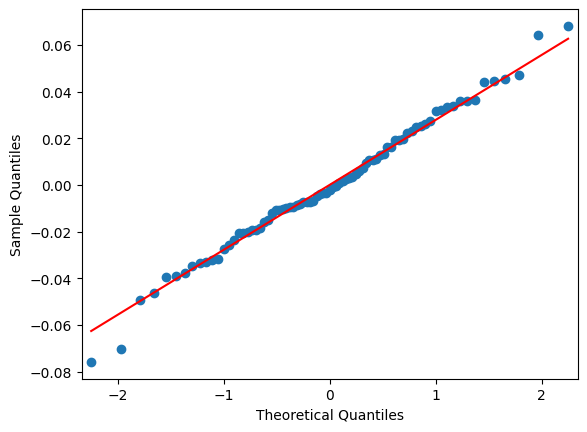

In [ ]:
stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Residuals look Gaussian (fail to reject H0)')
else:
    print('Residuals do not look Gaussian (reject H0)')

# plot the residuals
fig = sm.qqplot(residuals, line='s')
plt.show()

#### Homogeneity of Variance:

Statistics=68.875, p=0.000
Variances are not equal (reject H0)


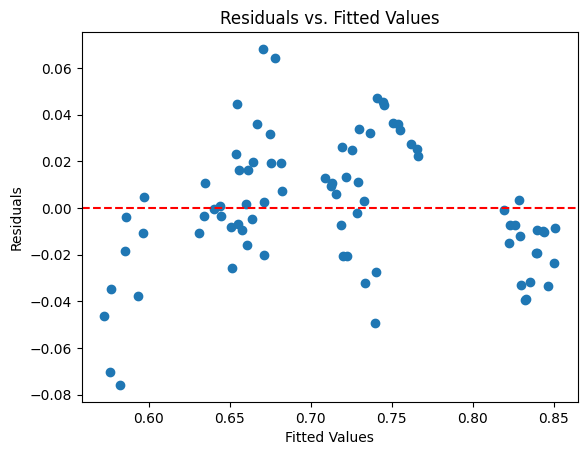

In [ ]:
stat, p = levene(grouped_df['rouge1_fmeasure_mean'], residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Variances are equal (fail to reject H0)')
else:
    print('Variances are not equal (reject H0)')

# Plot residuals vs. fitted values
fitted_vals = model_rouge1_fmeasure.fittedvalues
plt.scatter(fitted_vals, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()


#### Post-Hoc Analysis:

In [ ]:
# Perform Tukey HSD test for 'model'
tukey_model = pairwise_tukeyhsd(grouped_df['rouge1_fmeasure_mean'], grouped_df['model'])
print("\nTukey HSD Test for 'model':")
print(tukey_model)

# Perform Tukey HSD test for 'batch_size'
tukey_batch_size = pairwise_tukeyhsd(grouped_df['rouge1_fmeasure_mean'], grouped_df['batch_size'])
print("\nTukey HSD Test for 'batch_size':")
print(tukey_batch_size)

# Pairwise Tukey HSD test for 'max_new_tokens' and 'quantization'
# Perform Tukey HSD test for 'max_new_tokens'
tukey_max_new_tokens = pairwise_tukeyhsd(grouped_df['rouge1_fmeasure_mean'], grouped_df['max_new_tokens'])
print("\nTukey HSD Test for 'max_new_tokens':")
print(tukey_max_new_tokens)

# Perform Tukey HSD test for 'quantization'
tukey_quantization = pairwise_tukeyhsd(grouped_df['rouge1_fmeasure_mean'], grouped_df['quantization'])
print("\nTukey HSD Test for 'quantization':")
print(tukey_quantization)


Tukey HSD Test for 'model':
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
         group1                  group2         meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------
meta-llama/Llama-3.1-8B meta-llama/Llama-3.2-1B  -0.0848 0.0004 -0.1349 -0.0346   True
meta-llama/Llama-3.1-8B meta-llama/Llama-3.2-3B  -0.0068 0.9437  -0.057  0.0433  False
meta-llama/Llama-3.2-1B meta-llama/Llama-3.2-3B    0.078 0.0011  0.0278  0.1281   True
--------------------------------------------------------------------------------------

Tukey HSD Test for 'batch_size':
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      4  -0.0034 0.9883 -0.0597 0.0528  False
     1      8   0.0007 0.9996 -0.0556 0.0569  False
     4      8   0.0041 0.9833 -0.0521 0.0604  False
----------------

#### Model Summary:

In [ ]:
model_rouge1_fmeasure.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     rouge1_fmeasure_mean   R-squared:                       0.893
Model:                              OLS   Adj. R-squared:                  0.881
Method:                   Least Squares   F-statistic:                     74.85
Date:                  Wed, 04 Dec 2024   Prob (F-statistic):           8.40e-32
Time:                          00:42:32   Log-Likelihood:                 175.23
No. Observations:                    81   AIC:                            -332.5
Df Residuals:                        72   BIC:                            -310.9
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.8293      0.010     84.330      0.000       0.810       0.849
C(model)[T.meta-llama/Llama-3.2-1B]    -0.0848      0.008    -10.561      0.000      -0.101      -0.069
C(model)[T.meta-llama/Llama-3.2-3B]    -0.0068      0.008     -0.848      0.399      -0.023       0.009
C(batch_size)[T.4]                     -0.0034      0.008     -0.428      0.670      -0.019       0.013
C(batch_size)[T.8]                      0.0007      0.008      0.084      0.934      -0.015       0.017
C(max_new_tokens)[T.250]               -0.1102      0.008    -13.731      0.000      -0.126      -0.094
C(max_new_tokens)[T.500]               -0.1684      0.008    -20.978      0.000      -0.184      -0.152
C(quantization)[T.8.0]                  0.0207      0.008      2.583      0.012       0.005       0.037
C(quantization)[T.16.0]                 0.0096      0.008      1.196      0.236      -0.006       0.026
==============================================================================
Omnibus:                        0.395   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.099
Skew:                          -0.061   Prob(JB):                        0.951
Kurtosis:                       3.120   Cond. No.                         5.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Reports

- **Hyper-Parameters Tested**
    - **Models**: `Llama-3.2-1B`, `Llama-3.2-3B`, `Llama-3.1-8B`
    - **Batch Sizes**: `1`, `4`, `8`
    - **Max New Tokens**: `100`, `250`, `500`
    - **Precision**: `4-bit`, `8-bit`, `16-bit`

- **Levels for Each Experiment**
    - **Model**: 3 levels.
    - **Batch Size**: 3 levels.
    - **Max New Tokens**: 3 levels.
    - **Precision**: 3 levels.

- **Number of Repetitions**
  - Four repetitions were conducted for each configuration to ensure robustness and reliability of the results.

- **Design of Experiment**
  - **Full-Factorial**: All possible combinations of the levels were tested.
  - Total configurations: `3 (model) x 3 (batch_size) x 3 (max_new_tokens) x 3 (precision) = 81`.

- **Model Assumptions**
  - **Normality**: 
    - ..
  - **Homogeneity of variance**: 
    - ..

## ANOVA on Inference time

In [52]:
# Perform two-way ANOVA on 'time_taken'
model_time_taken = ols('time_taken_mean ~ C(model) + C(batch_size) + C(max_new_tokens) + C(quantization)', data=grouped_time_df).fit()
anova_table_time_taken = sm.stats.anova_lm(model_time_taken, typ=2)

# Display ANOVA results for time_taken
print("ANOVA Results for Time Taken:")
print(anova_table_time_taken)

ANOVA Results for Time Taken:
                         sum_sq    df          F        PR(>F)
C(model)            5912.214357   2.0  15.831908  2.001663e-06
C(batch_size)       6390.624741   2.0  17.113010  8.311076e-07
C(max_new_tokens)  20640.349660   2.0  55.271357  2.850019e-15
C(quantization)    19201.110692   2.0  51.417319  1.347040e-14
Residual           13443.718925  72.0        NaN           NaN


### Summary for Inference Time:

The ANOVA results show that all studied factors (**C(model)**, **C(batch_size)**, **C(max_new_tokens)**, **C(quantization)**) have a statistically significant impact on inference time (p < 0.001 for all factors). 

1. **C(model)**: The choice of model is a significant factor (F = 15.83, p = 2.00e-06). Different models lead to important variations in inference time, likely due to differences in architecture and size.

2. **C(batch_size)**: Batch size also significantly affects inference time (F = 17.11, p = 8.31e-07). Larger or smaller batch sizes can influence resource usage.

3. **C(max_new_tokens)**: This factor has the largest impact on inference time, with the highest F-statistic (F = 55.27, p = 2.85e-15). This is expected, as generating more tokens directly increases the inference duration.

4. **C(quantization)**: Quantization also has a significant effect on inference time (F = 51.42, p = 1.35e-14). Different techniques or levels of quantization can greatly reduce or increase the time required for inference.

5. **Residual Variability**: The residual sum of squares is relatively low compared to the main factors, indicating that the observed variations are well explained by the model.



#### Insights:
- **Parameter Optimization**: Managing **max_new_tokens** should be a top priority since it has the most significant impact.
- **Model Choice**: A detailed evaluation of trade-offs between performance and execution time is necessary.
- **Quantization**: Quantization is a key lever to reduce inference time while maintaining acceptable accuracy.
- **Batch Size**: While significant, its effect is less impactful than **max_new_tokens** and **quantization**, but adjustments could still yield performance gains.

These results could be visualized to highlight variations in inference time for each factor, especially **max_new_tokens** and **quantization**, which show the most pronounced effects.


# Conclusion

The main findings from the ANOVA analysis are that the parameter that influence the most the **ROUGE scores** and the **inference time** is the **maximum number of tokens generated**. The model and the quantization also have a significant impact on the ROUGE scores and the inference time. The batch size has no significant impact on the ROUGE scores but has a significant impact on the inference time.

So we conclude that the **maximum number of tokens generated is the most important parameter to optimize** for the queuing system when the system is under heavy load, but it is also important to note that it has a significant impact on the ROUGE scores. So finding a good ratio to not increase the inference time too much while keeping a good ROUGE score is important.

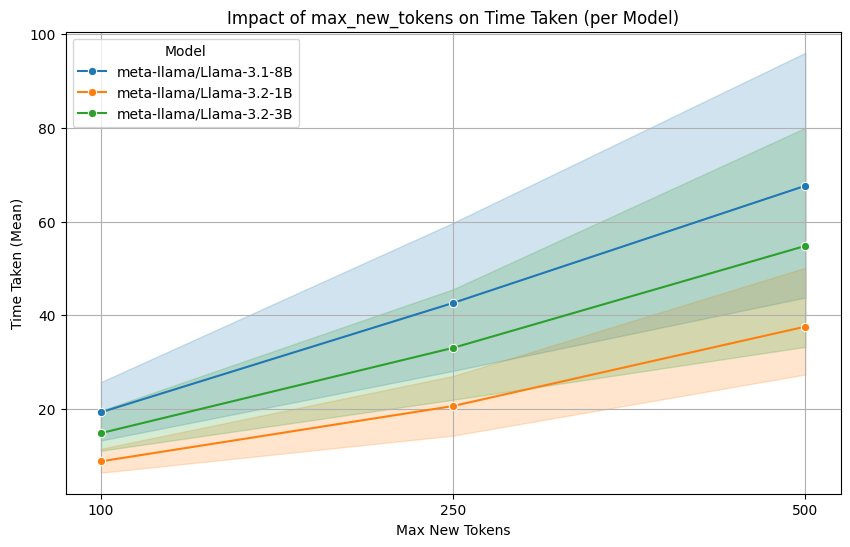

In [58]:
# Time taken vs. max_new_tokens for each model
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=grouped_time_df, 
    x='max_new_tokens', 
    y='time_taken_mean', 
    hue='model', 
    marker='o'
)
plt.title('Impact of max_new_tokens on Time Taken (per Model)')
plt.xlabel('Max New Tokens')
plt.ylabel('Time Taken (Mean)')
plt.legend(title='Model')
plt.grid(True)
plt.show()
